# Analysis Of Cookie Banners

**Get the cookie bodies and url from the temp file**



In [29]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and cates a new data frame.
import pandas as pd
import json

# A temporary variable to store the list of post content.
posts_tmp = list()
all = ''
with open('temp_file.txt') as file:
  all = file.read()
  all = all.split('\n')
  print(all)

i = 0
urls = []
while i < len(all):
    if all[i].startswith('http'):
      url = i
      txt = ''
      i += 1
      while all[i] != '':
        txt += all[i]
        i+=1
      if (txt != 'FailedToFindBanner'):
        posts_tmp.append((all[url], txt))
        urls.append(all[url].split('https://')[1])
    else:
      i += 1
print(posts_tmp)
# # Create the posts data frame.  
labels = ['url', 'body']
post_frame = pd.DataFrame(posts_tmp, columns=labels)

['https://uk250.co.uk', 'Got it!This website uses cookies to ensure you get the best experience on our website More infoCookie Consent plugin for the EU cookie law', '', 'https://gla.ac.uk', 'The University of Glasgow uses cookies for analytics and advertising.', 'Find out more about our Privacy policy.', ' privacy settings', 'close', '', 'https://bbk.ac.uk', 'FailedToFindBanner', '', 'https://bathspa.ac.uk', 'FailedToFindBanner', '', 'https://mango.com', 'We use our own and third-party cookies for analytical purposes and to show you advertising and personalised content based on a profile prepared from your browsing habits. You can accept all the cookies or manage your preferences in the settings panel. For more information, consult theCookies Policy.', '', 'https://aber.ac.uk', 'FailedToFindBanner', '', 'https://gitlab.com', 'FailedToFindBanner', '', 'https://anglia.ac.uk', 'We use cookies to improve your browsing experience, monitor how our site is used, and aid us with advertising. 

### Import spacy

In [30]:
!python -m spacy download en

import spacy

import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("spacy", "2.0")

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
print(nlp.pipeline)
print(nlp.pipe_names)
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
# Verify they are empty.
print(nlp.pipeline)


     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
spacy version 2.2.4 is
OK
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7effa13c2910>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7eff875ae2f0>)]
['tagger', 'parser']
[]


### Tokenize and Normalize the text of the cookies (data pre-processing)

In [31]:

all_stopwords = nlp.Defaults.stop_words

# remove stop words
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    if token not in all_stopwords:
      tokens.append(token)
  return tokens

# This tokenizes the body posts and creates vector of tokens for each post.
all_posts_tokenized = post_frame.body.apply(spacy_tokenize)

import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

In [32]:
# take only lowercase letters and numbers, remove noise
def normalize(tokens):
  normalized = list()
  for token in tokens:
    if (token.is_alpha or token.is_digit):
      lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
      if lemma not in all_stopwords:
        normalized.append(lemma)
  return normalized

In [33]:
normalized_tokens = normalize(flat_tokens)

## Count the words frequency in all cookies - get the 10 most frequently found ones

In [34]:
posts_to_load = len(posts_tmp)

In [35]:
from itertools import islice

# Parallel arrays of the post keys and values (data pre-processing step)
post_vals = list()
post_keys = list()

for post in islice(post_frame.itertuples(index=True, name='Pandas'), posts_to_load):
    post_keys.append(getattr(post, 'url'))
    post_vals.append(getattr(post,'body'))
print(post_vals)

['Got it!This website uses cookies to ensure you get the best experience on our website More infoCookie Consent plugin for the EU cookie law', 'The University of Glasgow uses cookies for analytics and advertising.Find out more about our Privacy policy. privacy settingsclose', 'We use our own and third-party cookies for analytical purposes and to show you advertising and personalised content based on a profile prepared from your browsing habits. You can accept all the cookies or manage your preferences in the settings panel. For more information, consult theCookies Policy.', 'We use cookies to improve your browsing experience, monitor how our site is used, and aid us with advertising. By continuing to use our site you are agreeing to our privacy and cookies policy.', 'This website uses cookies to improve your experience and distinguish you from other users. By continuing to browse this site, we assume you agree to this. For more information please view our cookie policy.', 'We use cooki

In [36]:

def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [37]:
from collections import Counter
# tokenize and normalize ALL cookies the count themm using Counter method
list1 = normalized_tokens
counts = Counter(list1)
counts.most_common(10)

[('cooky', 183),
 ('use', 177),
 ('website', 82),
 ('site', 74),
 ('experience', 71),
 ('policy', 58),
 ('cookie', 54),
 ('privacy', 42),
 ('information', 41),
 ('continue', 34)]

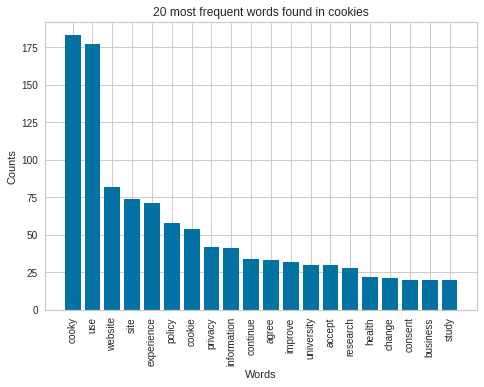

In [38]:
# plot the mkost frequent words
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = [ word for (word,count) in counts.most_common(20)]
count = [ count for (word,count) in counts.most_common(20)]

ax.bar(words,count)
plt.xticks(rotation='vertical')
ax.set_xlabel('Words')
ax.set_title('20 most frequent words found in cookies')
ax.set_ylabel('Counts')

plt.show()

### Count the length (number of tokens) of the cookies 

In [47]:
lengths = []
less_informative_counts = 0
medium_informative_counts = 0
very_informative_counts = 0
for cookie in post_vals:
  tokenized_cookie = tokenize_normalize(cookie)
  # remove noisy cookies
  
  if (len(tokenized_cookie)<100):
    lengths.append(len(tokenized_cookie))
    if (len(tokenized_cookie)<=10):
      less_informative_counts += 1
      print(cookie)
    elif len(tokenized_cookie) < 30:
      medium_informative_counts += 1
    else:
      very_informative_counts  += 1


We use cookies to give you the best possible experienceIf you don't want to accept cookies you can change preferences
We have updated our cookie policy. We use cookies to ensure that we give you the best experience on our website.
We use cookies to ensure that we give you the best experience on our website. Learn more about cookies on this siteClose this message 
We use cookies on this site to enhance your user experienceBy clicking the Accept button, you agree to us doing so.
This website uses cookies to ensure you get the best experience on our website.AcceptMore Information 
We use cookies to personalise your experience on this site and others. For more information, visit our Privacy & Cookies page.
YOUR CHOICE REGARDING COOKIESWe use cookies to optimise site functionality and give you the best possible experience.
This website uses cookies to ensure you get the best experience during your visit. Read our Cookie PolicyAccept and close
We use cookies to ensure the best experience on 

In [46]:
very_informative_counts

13

Text(0.5, 1.0, 'Distribution of the number of tokens from each banner')

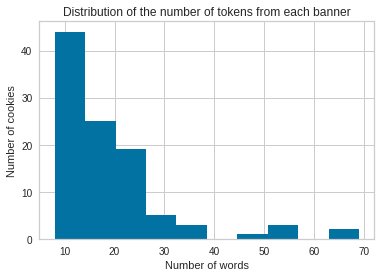

In [40]:
# we plot all counts using log scale (Because most counts are small, and there are a few counts with anomalities)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(lengths, bins=10)
plt.ylabel('Number of cookies')
plt.xlabel('Number of words');
plt.title('Distribution of the number of tokens from each banner')


In [41]:
import numpy
n = np.array(lengths)
index_formative = np.argwhere(n>20)
index_unformative = np.argwhere(n<13)

In [42]:
for i in index_unformative.tolist():
  print(post_vals[i[0]])

The University of Glasgow uses cookies for analytics and advertising.Find out more about our Privacy policy. privacy settingsclose
We use cookies to enhance your online experienceTo find out more, please read ourupdated privacy policy and cookie policy
We use cookies to give you the best possible experienceIf you don't want to accept cookies you can change preferences
© University of Bath 2022DisclaimerFreedom of informationModern slavery statementPrivacy and cookie policyStaying COVID-19 SecureTransparency informationWebsite accessibility statement
This site uses cookies and by using the site you are consenting to this. Find out more about what cookies we use and why in our privacy policy.
Our website uses cookies to enhance your experience. By continuing to browse the site you are agreeing to our use of cookies. You can find out more and control your Cookie settings on our Cookie Policy page.
Connect with us 中文网Information for:Current studentsNew studentsStaffAlumni and supportersQui

### Clustering

In [15]:

all_stopwords = nlp.Defaults.stop_words

# add everything, including stop words
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

# take only lowercase letters and numbers, remove noise
def normalize(tokens):
  normalized = list()
  for token in tokens:
    if (token.is_alpha or token.is_digit):
      lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
      if lemma not in all_stopwords:
        normalized.append(lemma)
  return normalized
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,ngram_range=(1,2),max_features = 50000,sublinear_tf=True)
vectorizer.fit(post_vals)
document_matrix = vectorizer.transform(post_vals)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


**Exercise:** Next, lets pick a post to compute similarity with. Put the content of a post in the variable called `my_string`

## KMeans clustering

What's in the Reddit dataset? When we want to explore a dataset, one method is to apply clustering and then to inspect the result.

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11, n_init=5,verbose=10,random_state = 0).fit(document_matrix)

Initialization complete
Iteration 0, inertia 144.7803193586571
Iteration 1, inertia 81.52958585467778
Iteration 2, inertia 81.31777489082366
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 146.06779450592865
Iteration 1, inertia 81.3202080117942
Iteration 2, inertia 81.107991583064
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 146.09489941302462
Iteration 1, inertia 81.49544347700683
Iteration 2, inertia 81.26517918385875
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 149.98402658428355
Iteration 1, inertia 81.0523399117047
Iteration 2, inertia 80.9195823067297
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 145.04595770264436
Iteration 1, inertia 81.53930710927557
Iteration 2, inertia 81.05243930750397
Converged at iteration 2: strict convergence.


In [18]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
num_clusters = 11
for i in range(num_clusters):
  print("Cluster %d:" % i)
  for ind in order_centroids[i, :20]:
    print(' %s' % terms[ind])
  print()

Cluster 0:
 analytics
 notice
 privacy
 university
 advertise
 advertise analytics
 use
 university glasgow
 settingsclose
 privacy settingsclose
 glasgow
 glasgow use
 analytics privacy
 policy privacy
 numb
 website
 use cooky
 cooky
 cooky analytics
 medium

Cluster 1:
 cookie policy
 use
 cooky
 find
 user
 continue browse
 browse site
 policy
 use cooky
 cookie
 website
 browse
 user experience
 website use
 continue
 cooky improve
 site
 experience
 accordance cookie
 cooky enhance

Cluster 2:
 change
 browser
 help improve
 change browser
 disable change
 disable
 help
 improve
 cooky enable
 cooky
 enable
 necessary
 market
 cooky disable
 cooky help
 market cooky
 cookiesnecessary
 new
 essential
 necessary cooky

Cluster 3:
 cooky
 accept cooky
 accept
 device
 click
 view
 cooky device
 privacy
 improve
 site
 view privacy
 privacy page
 store
 click accept
 information
 enhance
 use
 manage
 browse
 store cooky

Cluster 4:
 website
 website agree
 cooky website
 use website

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We can also look at the cluster assignments.  Each post is assigned a cluster label. 

In [19]:
"""
0: Analytics
1: Enhance Browser experience

"""


import collections
# Group the posts by their cluster labels.
clustering = collections.defaultdict(list)
for idx, label in enumerate(kmeans.labels_):
  clustering[label].append(idx)


In [20]:
for cluster, indices in clustering.items():
  print("\nCluster:", cluster, " Num posts: ", len(indices))
  cur_docs = 0
  for index in indices:
    post_contents = post_vals[index].replace('\n', '')
    print(index, post_keys[index], (post_contents) if len(post_contents) > 75 else post_contents)
    cur_docs+= 1


"""
0: advertising and analytics
1: enhance browser, website experience
2: Disable cookies
3: go to Cookie Policy page to see how cookies are stored on the device
4: remembering your preferences
5: best customer experience
6: otpimise site functionality
7: By using this website, you consent to using cookies
8: use cookies and similar technologies to understand our visitors’ experiences
9: optional cookies
10: Privacy Statement; 


"""


Cluster: 5  Num posts:  15
0 https://uk250.co.uk Got it!This website uses cookies to ensure you get the best experience on our website More infoCookie Consent plugin for the EU cookie law
16 https://birmingham.ac.uk We use cookies to track visits to our website and to deliver targeted messages about the University to users.We do not store personal details.For more information or to change your cookie settings, see our Cookie Policy. ACCEPT COOKIES What are cookies?
22 https://hud.ac.uk We have updated our cookie policy. We use cookies to ensure that we give you the best experience on our website.
27 https://kingston.ac.uk We use cookies to ensure that we give you the best experience on our website. Learn more about cookies on this siteClose this message 
29 https://le.ac.uk Accept cookiesWe use cookies to make sure you get the best experience on our website; you can read ourPrivacy Policy to learn more.Cookie Consent plugin for the EU cookie law
32 https://ljmu.ac.uk Cookie SettingsSo

'\n0: advertising and analytics\n1: enhance browser, website experience\n2: Disable cookies\n3: go to Cookie Policy page to see how cookies are stored on the device\n4: remembering your preferences\n5: best customer experience\n6: otpimise site functionality\n7: By using this website, you consent to using cookies\n8: use cookies and similar technologies to understand our visitors’ experiences\n9: optional cookies\n10: Privacy Statement; \n\n\n'

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

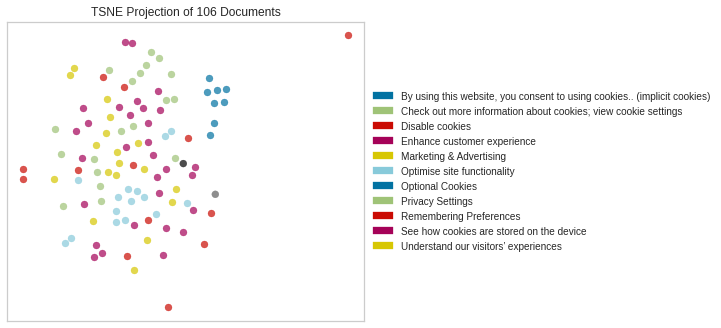

In [21]:
from yellowbrick.text import TSNEVisualizer

"""
    \item Marketing \& Advertising
    \item Enhance customer experience
    \item Disable cookies
    \item Go to Cookie Policy page to see how cookies are stored on the device
    \item Remembering Preferences
    \item Optimise site functionality
    \item By using this website, you consent to using cookies.. (implicit cookies)
    \item Understand our visitors’ experiences
    \item Privacy Statement
"""
map = {0:'Marketing & Advertising', 1:'Enhance customer experience', 
       2:'Disable cookies ', 3:'See how cookies are stored on the device', 4:'Remembering Preferences', 
       5:'Optimise site functionality', 6:'By using this website, you consent to using cookies.. (implicit cookies)', 
       7:'Check out more information about cookies; view cookie settings', 8:'Understand our visitors’ experiences', 9:'Optional Cookies',
       10:'Privacy Settings'}
labels = kmeans.predict(document_matrix)
tsne = TSNEVisualizer()
tsne.fit(document_matrix, [map[k] for k in labels])

tsne.set_title('Cookie Body Text clustering')
tsne.show()

In [22]:
# Example cluster range
cluster_range = range(3,10)

#### Elbow method

The code below plots K-Means using the [Elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). The Sillhuette coeficient finds the best number of clusters. 

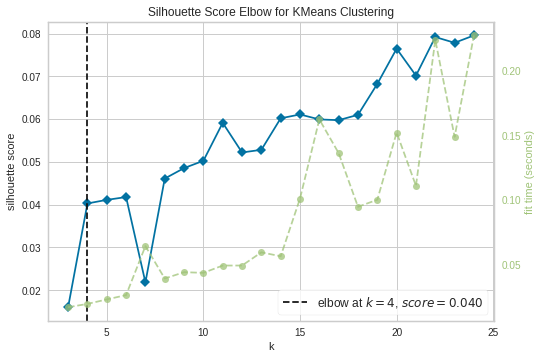

In [23]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++', n_init=3, random_state=42)
# Multiple metrics are available, see the documentation for details. 
visualizer = KElbowVisualizer(model, metric='silhouette', k=(3, 25))
visualizer.fit(document_matrix)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Which cookies are uninformative using cosine similarity of the embeddings of the cookies bodies

In [24]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 3.8 MB 32.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 6.5 MB 34.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=ad2d2cd136242a8e75832287075150434b7c6805cdd28b9eb981f0f75b1cd63e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [25]:
cats = {'advertising, analytics, and marketing analyse usage or analyze traffic': 0.6429,
'better customer experience':0.4823,
'disable': 0.4565,
'how are stored on the device': 0.6473,
'remembering your preferences': 0.6139,
'best customer experience': 0.5014,
'otpimise site functionality': 0.6508,
'understand our visitors experiences': 0.6561,
'privacy statement': 0.5817}

headers = ['Marketing & Advertising',
'Enhance customer experience',
'Disable cookies/ Change cookie settings',
'Cookies are stored on device',
'Remember user preferences',
'Enhance customer experience',
'otpimise site functionality',
'Understand visitors experiences',
'Privacy Statement',
]

thresholds = []

In [26]:
from sentence_transformers import SentenceTransformer
import torch 
from torch import nn

def get_cookies_from_cat (cat,thres):
  cos_sim = nn.CosineSimilarity(dim=0)

  phrase_list = post_vals
  query = cat
  model = SentenceTransformer('whaleloops/phrase-bert')
  phrase_embs = model.encode( [query] + phrase_list )
  query_emb = phrase_embs[0]
  all = []
  for i,emb in enumerate(phrase_embs[1:]):
      cos = cos_sim( torch.tensor(query_emb), torch.tensor(emb))
      if (cos>=thres):
        all.append((cos, post_vals[i], urls[i]))

  return sorted(all, key=lambda x: -x[0])

In [27]:
counts = []
for cat, thres in cats.items():
  cookies_list = get_cookies_from_cat(cat,thres)
  counts.append(len(cookies_list))


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/670 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
   

plt.barh(headers[::-1],counts[::-1])
plt.title('What do cookies mention in their bodies?')
plt.xlabel('Number of cookies which mention category')
plt.show()